In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# Machine Learning

#### 1) Gere uma amostra de 500 dados a partir de um polinômio de grau 4 com ruído. Compare os seguintes modelos Linear, Quadrático, Cúbico e Quártico construídos a partir de amostras com os seguintes tamanhos: 5, 10, 25, 50 e 100.

In [65]:
def generate_data(coefficients, from_to, num_points, noise_scale):

    # Gerando valores de x
    x = np.linspace(*from_to, num_points)
    # Gerando ruído
    noise = np.random.normal(loc=0, scale=noise_scale, size=len(x))
    # Gerando valores de y sem ruído
    y_true = np.polyval(coefficients, x)
    # Gerando valores de y com ruído
    y = y_true + noise

    return x, y, y_true

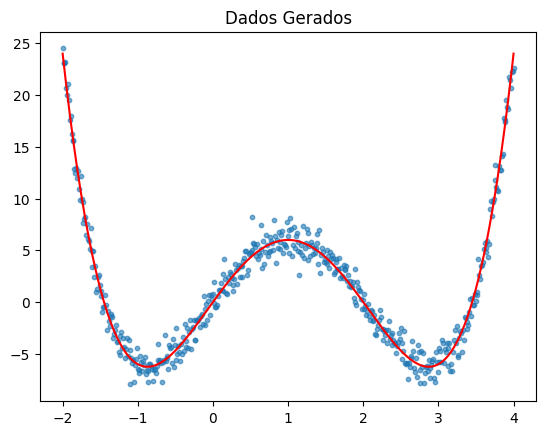

In [66]:
x, y, y_true = generate_data(coefficients=[1, -4, -1, 10, 0], from_to=[-2, 4], num_points=500, noise_scale=1)

plt.scatter(x, y, label="Série com Ruído", alpha=0.6, s=10)
plt.plot(x, y_true, color="red")
plt.title("Dados Gerados")
plt.show()

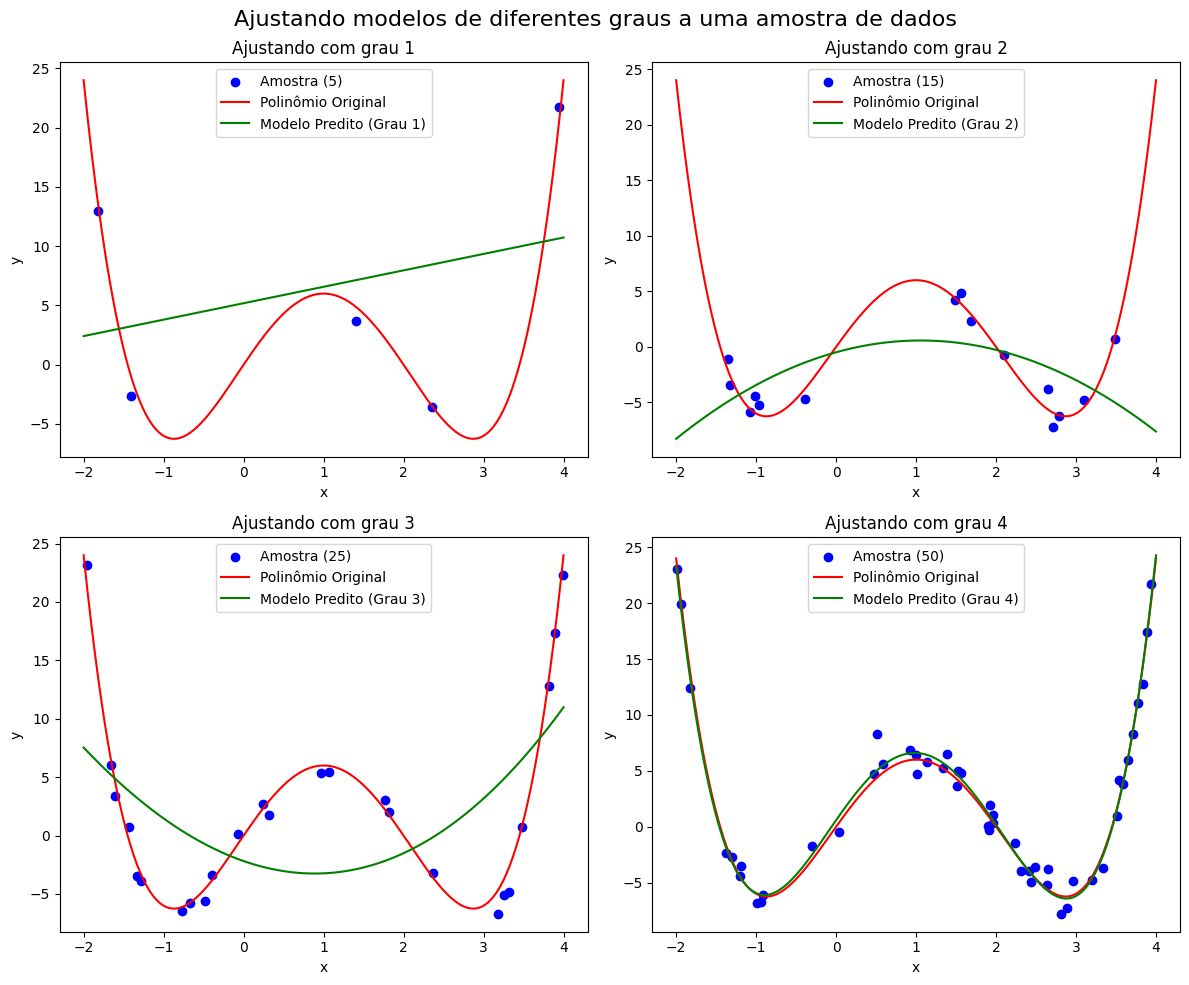

In [67]:
# Função para ajustar um modelo polinomial a uma amostra de dados

def fit_model(x, x_sample, y_sample, degree):
    # Obtendo coeficientes de um polinômio de grau especificado que se ajusta à amostra
    coeffs = np.polyfit(x_sample, y_sample, degree)
    model = np.poly1d(coeffs)
    y_pred = model(x)

    return coeffs, model, y_pred

def plot_model(x_range, x_sample, y_sample, y_true, y_pred, degree, ax):
    # Plotando amostra, polinômio original e modelo ajustado
    ax.scatter(x_sample, y_sample, label=f"Amostra ({len(x_sample)})", color='blue')
    ax.plot(x_range, y_true, color='red', label="Polinômio Original")
    ax.plot(x_range, y_pred, color='green', label="Modelo Predito (Grau {})".format(degree))
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Ajustando com grau {degree}")

# Criando uma matriz de plots para comparar modelos com diferentes graus
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Ajustando modelos de diferentes graus a uma amostra de dados", fontsize=16)

# Tamanho das amostras que serão usadas para ajustar os modelos de graus 1, 2, 3 e 4
sample_sizes = [5, 15, 25, 50]

# Gerando e ajustando modelos para diferentes graus
for i, sample_size in enumerate(sample_sizes):
    # Obtendo amostra de dados aleatória
    xy = list(zip(x, y))
    np.random.shuffle(xy)
    x_sample, y_sample = zip(*xy[:sample_size])
    degree = i + 1
    
    # Acessamos os plots da matriz usando axs[i // 2, i % 2] (divisa inteira e resto da divisão)
    # i // 2 é a linha e i % 2 é a coluna
    # i varia de 0 a 3, então i // 2 varia de 0 a 1 e i % 2 varia de 0 a 1
    # assim, acessamos os plots (0, 0), (0, 1), (1, 0) e (1, 1) da matriz

    coeffs, model, y_pred = fit_model(x, x_sample, y_sample, degree)
    plot_model(x, x_sample, y_sample, y_true, y_pred, degree, axs[i // 2, i % 2])

plt.tight_layout()
plt.show()


In [68]:
x, y, y_true = generate_data(coefficients=[1, -4, -1, 10, 0], from_to=[-2, 4], num_points=40, noise_scale=1)

In [69]:
# Ajustando Modelos
coeffs_1, model_1, y_pred_1 = fit_model(x=x, x_sample=x, y_sample=y, degree=1)
coeffs_2, model_2, y_pred_2 = fit_model(x=x, x_sample=x, y_sample=y, degree=2)

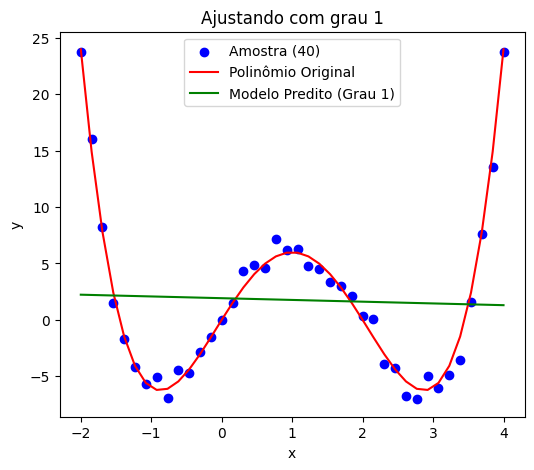

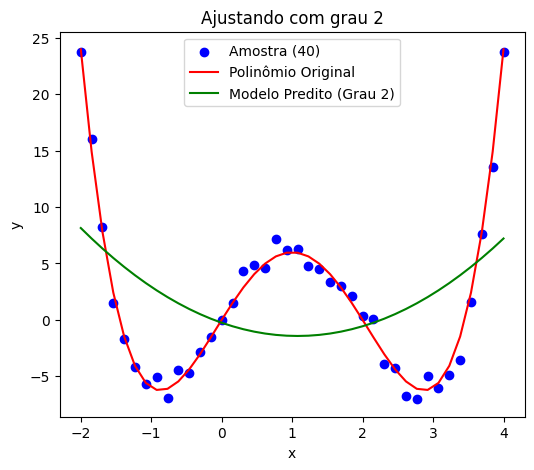

In [70]:
# Plotando Modelos
fig, ax = plt.subplots(figsize=(6, 5))
plot_model(x_range=x, y_sample=y, x_sample=x, y_true=y_true, y_pred=y_pred_1, degree=1, ax=ax)
fig2, ax2 = plt.subplots(figsize=(6, 5))
plot_model(x_range=x, y_sample=y, x_sample=x, y_true=y_true, y_pred=y_pred_2, degree=2, ax=ax2)


#### 2) Gere uma amostra de 40 dados a partir de um polinômio de grau 4 com ruído.
##### a) Estime um modelo Linear e um modelo Quadrático e compare esses modelos usando um conjunto de validação.
##### b) Explore o efeito do tamanho do conjunto de validação k na estimativa. Ou seja, brinque com um Monte Carlo para calcular a variância do Erro de validação e a variância de um dos parâmetros do modelo. Note que se o tamanho k do conjunto de validação aumenta, então o tamanho da amostra de treino 40 − k diminui.

In [71]:
def split_data(x, y, validation_size):
    # Embaralhando os índices dos dados
    indices = np.arange(len(x))
    np.random.shuffle(indices)

    # Dividindo os dados em conjuntos de treinamento e validação
    validation_indices = indices[:validation_size]
    training_indices = indices[validation_size:]
    x_validation, y_validation = x[validation_indices], y[validation_indices]
    x_training, y_training = x[training_indices], y[training_indices]

    return x_training, y_training, x_validation, y_validation

In [72]:
def evaluate_model(x_training, y_training, x_validation, y_validation, degree):
    # Ajustando o modelo com os dados de treinamento
    coeffs = np.polyfit(x_training, y_training, degree)
    model = np.poly1d(coeffs)

    # Predizendo valores de y com o modelo para os dados de validação
    y_pred = model(x_validation)

    def calculate_error(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    # Calculando o erro de validação
    error = calculate_error(y_validation, y_pred)

    return error, coeffs


def monte_carlo_experiment(x, y, degrees, validation_sizes, num_iterations):
    errors = np.zeros((len(validation_sizes), len(degrees), num_iterations))
    coeffs_dict = {degree:{i : [] for i in validation_sizes} for degree in degrees}
    coeffs_variances = {degree:{i : [] for i in validation_sizes} for degree in degrees}

    for d, degree in enumerate(degrees):
        for v, validation_size in enumerate(validation_sizes):
            for i in range(num_iterations):
                x_training, y_training, x_validation, y_validation = split_data(x, y, validation_size=validation_size)
                error, coeffs = evaluate_model(x_training, y_training, x_validation, y_validation, degree)

                errors[v, d, i] = error
                coeffs_dict[degree][validation_size].append(list(coeffs))

                # if (i + 1) % 10 == 0:
                #     print(f"Iteração {i + 1}/{num_iterations} - Tamanho do conj. valid.: {validation_size} - Grau: {degree}")
                #     print(f"Erro de Validação: {error:.4f} - Coeficientes: {coeffs}\n")

    # Obtendo a variância de cada coeficiente para cada grau e tamanho de validação
    for degree in coeffs_dict.keys():
        for validation_size in coeffs_dict[degree].keys():
            coeffs_variances[degree][validation_size] = list(np.var(coeffs_dict[degree][validation_size], axis=0))

    # Calculando a média dos erros para cada grau e tamanho de validação
    mean_errors = np.mean(errors, axis=2)
    
    return mean_errors, coeffs_variances

In [73]:
# Parâmetros do experimento de Monte Carlo
degrees = [1, 2]  # Modelos de grau 1 e 2
validation_sizes = [5, 10, 15, 20, 25, 30]  # Tamanhos de amostra para validação
num_iterations = 10000  # Número de iterações do experimento

mean_errors, coeffs_variances = monte_carlo_experiment(x, y, degrees, validation_sizes, num_iterations)

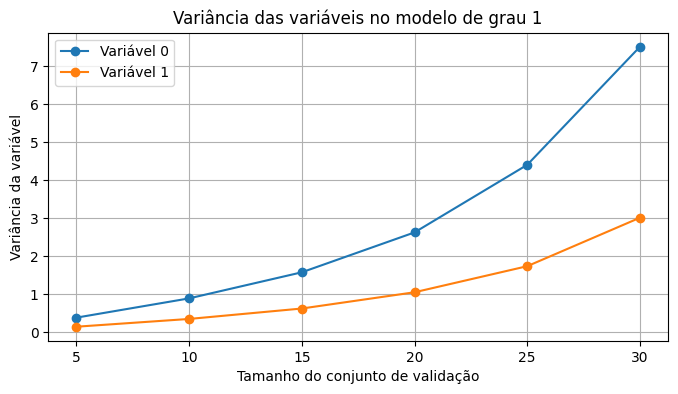

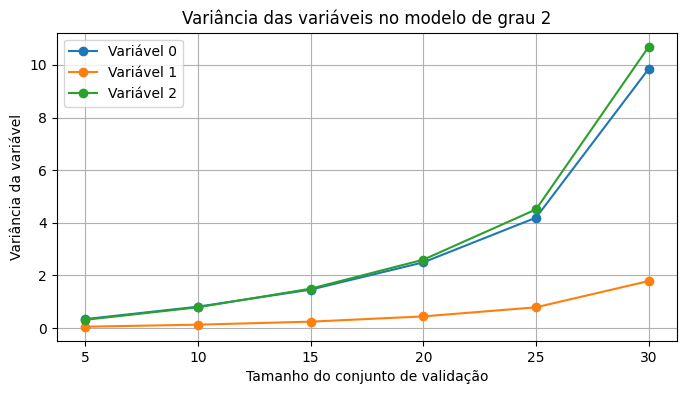

In [74]:
for (degree,var_count) in [(1,2),(2,3)]:
    plt.figure(figsize=(8, 4))
    plt.title(f"Variância das variáveis no modelo de grau {degree}")
    plt.xlabel("Tamanho do conjunto de validação")
    plt.ylabel("Variância da variável")
    for var_index in range(0,var_count):  # Variables 1 and 2
        vars = [coeffs_variances[degree][sample_size][var_index - 1] for sample_size in coeffs_variances[1]]
        plt.plot(list(coeffs_variances[degree].keys()), vars,  marker='o', label=f"Variável {var_index }")
    plt.legend()
    plt.grid(True)
    plt.show()


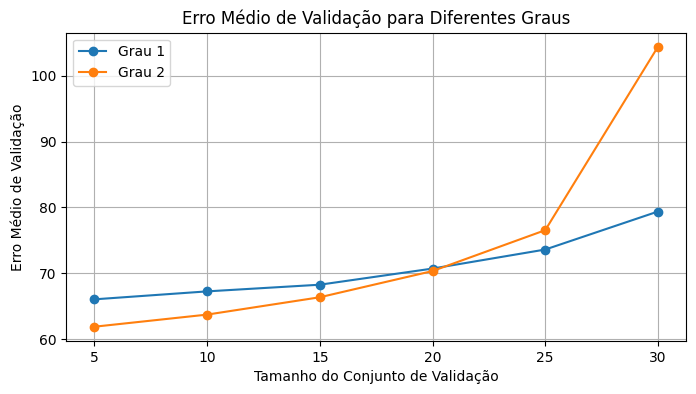

In [75]:
# Plot Validation Errors
plt.figure(figsize=(8, 4))
for d, degree in enumerate(degrees):
    plt.plot(validation_sizes, mean_errors[:, d], marker='o', label=f"Grau {degree}")
plt.xlabel("Tamanho do Conjunto de Validação")
plt.ylabel("Erro Médio de Validação")
plt.title("Erro Médio de Validação para Diferentes Graus")
plt.legend()
plt.grid(True)
plt.show()

# Modelos Lineares

#### 1) Gere dados da função $ f (x) = sin(x) + ε $ onde $ ε ∼ N(0, 25) $. Construa um modelo de função de base radial com bases dadas por uma gaussiana, isto é, $ φ(x) = exp(\frac{−(x − μ)2}{2σ^2})$  Determine os valores de $μ$ e $σ$ antes de treinar o modelo. Utilize o método do gradiente descendente para minimizar o erro de treinamento.

In [126]:
class ModeloRBF:
    def __init__(self, num_bases, taxa_aprendizado, num_epocas):
        # Inicializando os parâmetros do modelo
        self.num_bases = num_bases
        self.taxa_aprendizado = taxa_aprendizado
        self.num_epocas = num_epocas

        # Inicializa médias e desvios para funções de base Gaussianas
        self.medias = np.linspace(-2 * np.pi, 2 * np.pi, num_bases)
        self.desvio = (2 * np.pi) / num_bases

    def base_gaussiana(self, x, media, desvio):
        # Calcula o valor da função de base Gaussiana para um dado x e centro
        return np.exp(-((x - media)**2) / (2 * desvio**2))

    def construir_design_matrix(self, x):
        # Constrói a matriz de explicatorias usando funções de base Gaussianas para o input x
        matriz_projeto = np.zeros((len(x), self.num_bases))
        for i, media in enumerate(self.medias):
            # Preenche cada coluna com valores de função de base para cada média
            matriz_projeto[:, i] = self.base_gaussiana(x, media, self.desvio)
        return matriz_projeto

    def treinar(self, x, y):
        # Inicializa os pesos com valores aleatórios
        self.pesos = np.random.randn(self.num_bases)

        # Loop de treinamento ao longo das épocas
        for epoca in range(self.num_epocas):
            # Constrói a matriz de explicatorias para os inputs atuais
            matriz_projeto = self.construir_design_matrix(x)
            
            # Faz predições usando a matriz de projeto e os pesos atuais
            y_predito = np.dot(matriz_projeto, self.pesos)
            
            # Calcula o erro de predição
            erro = y_predito - y
            eqm = np.mean(erro**2)
            
            # Calcula o gradiente da perda em relação aos pesos
            gradiente = np.dot(matriz_projeto.T, erro)
            
            # Atualiza os pesos usando descida de gradiente
            self.pesos -= self.taxa_aprendizado * gradiente

            if (epoca+1) % 10 == 0:
                print(f"Época {epoca+1}/{self.num_epocas} - EQM: {eqm:.4f}")

    def prever(self, x):
        # Gera previsões usando o modelo treinado
        matriz_projeto = self.construir_design_matrix(x)
        return np.dot(matriz_projeto, self.pesos)

Época 10/1000 - EQM: 24.4755
Época 20/1000 - EQM: 24.2919
Época 30/1000 - EQM: 24.1529
Época 40/1000 - EQM: 24.0468
Época 50/1000 - EQM: 23.9650
Época 60/1000 - EQM: 23.9015
Época 70/1000 - EQM: 23.8517
Época 80/1000 - EQM: 23.8124
Época 90/1000 - EQM: 23.7811
Época 100/1000 - EQM: 23.7560
Época 110/1000 - EQM: 23.7356
Época 120/1000 - EQM: 23.7191
Época 130/1000 - EQM: 23.7055
Época 140/1000 - EQM: 23.6943
Época 150/1000 - EQM: 23.6850
Época 160/1000 - EQM: 23.6773
Época 170/1000 - EQM: 23.6707
Época 180/1000 - EQM: 23.6652
Época 190/1000 - EQM: 23.6606
Época 200/1000 - EQM: 23.6566
Época 210/1000 - EQM: 23.6532
Época 220/1000 - EQM: 23.6504
Época 230/1000 - EQM: 23.6479
Época 240/1000 - EQM: 23.6457
Época 250/1000 - EQM: 23.6439
Época 260/1000 - EQM: 23.6423
Época 270/1000 - EQM: 23.6409
Época 280/1000 - EQM: 23.6396
Época 290/1000 - EQM: 23.6386
Época 300/1000 - EQM: 23.6377
Época 310/1000 - EQM: 23.6369
Época 320/1000 - EQM: 23.6362
Época 330/1000 - EQM: 23.6355
Época 340/1000 - EQ

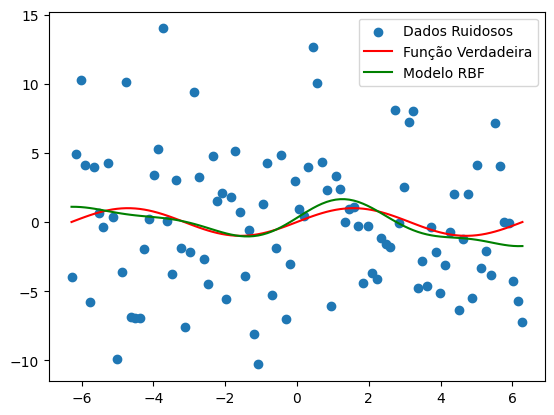

In [127]:
# Gera dados
x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
e = np.random.normal(0, 5, len(x))

y_verdadeiro = np.sin(x)
y_ruidoso = y_verdadeiro + e

# Cria e treina o modelo RBF
num_bases = 6
taxa_aprendizado = 0.001
num_epocas = 1000

modelo_rbf = ModeloRBF(num_bases, taxa_aprendizado, num_epocas)
modelo_rbf.treinar(x, y_ruidoso)

# Faz previsões usando o modelo RBF treinado
y_rbf = modelo_rbf.prever(x)

# Visualiza os dados e o modelo RBF
plt.scatter(x, y_ruidoso, label='Dados Ruidosos')
plt.plot(x, y_verdadeiro, color='red', label='Função Verdadeira')
plt.plot(x, y_rbf, color='green', label='Modelo RBF')
plt.legend()
plt.show()


#### 2) Explore os códigos do modelo de regressão linear utilizados nos dados de diabetes do Sklearn.
##### a) Teste outros scores no modelo.
##### b) Teste outros parâmetros para a função SGDRegression.

In [112]:
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

np.random.seed(0)

class MySklearningModel:
    def __init__(self, model, df, independent_variable_list, dependent_variable, cross_validator=None):
        self.model = model
        self.cross_validator = cross_validator
        self.independent_variable_list = independent_variable_list
        self.dependent_variable = dependent_variable
        self.X = df[self.independent_variable_list].values
        self.y = np.squeeze(df[[self.dependent_variable]].values)

    def run_sklearn_regression(self, score_list):
        scalar = StandardScaler()
        pipeline = Pipeline([('transformer', scalar), ('estimator', self.model)])
        results = model_selection.cross_validate(pipeline, self.X, self.y, cv=self.cross_validator, scoring=score_list, return_train_score=True)
        
        for score in score_list:
            print(f'\n{score}:')
            print(f'Train - Mean: {np.mean(results["train_" + score])} Standard Error: {np.std(results["train_" + score])}')
            print(f'Test - Mean: {np.mean(results["test_" + score])} Standard Error: {np.std(results["test_" + score])}')

    def fit_sklearn_regression(self):
        self.model.fit(self.X, self.y)
        
    def get_parameters(self):
        print(f'\nIntercept: {self.model.intercept_}')
        print(f'Coefficients: {self.model.coef_}')

class SklearnDatasets:
    def __init__(self, loadFunction, targetName='Target'):
        self.loadFunction = loadFunction
        self.targetName = targetName
        
    def dataset_to_dataframe(self):
        data = self.loadFunction()
        self.featuresNames = list(data.feature_names)
        targetData = data.target
        featuresData = data.data
        self.df = pd.DataFrame(featuresData, columns=self.featuresNames)
        self.df[self.targetName] = targetData

# Load Data
diabetes = SklearnDatasets(datasets.load_diabetes, 'Diabetes')
diabetes.dataset_to_dataframe()
df = diabetes.df
independent_variable_list = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
number_splits = 5
dependent_variable = 'Diabetes'
scores_list = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

print('SGD')
model = linear_model.SGDRegressor(penalty=None, tol=1e-8, max_iter=100000, learning_rate='constant', eta0=0.0000001)
cross_validator = model_selection.KFold(n_splits=number_splits, shuffle=True, random_state=0)
my_linear_model = MySklearningModel(model, df, independent_variable_list, dependent_variable, cross_validator)

my_linear_model.run_sklearn_regression(scores_list)
my_linear_model.fit_sklearn_regression()
my_linear_model.get_parameters()


SGD

neg_mean_squared_error:
Train - Mean: -2892.232090140965 Standard Error: 65.21694479368657
Test - Mean: -2996.4317231813952 Standard Error: 244.20631499621672

neg_mean_absolute_error:
Train - Mean: -43.4383276356647 Standard Error: 0.40733399879245946
Test - Mean: -44.32325365503739 Standard Error: 1.358273817779201

r2:
Train - Mean: 0.5117021299296811 Standard Error: 0.022372584887696816
Test - Mean: 0.4858168916676924 Standard Error: 0.09074975470880167

Intercept: [150.30268556]
Coefficients: [ 2.96747636  0.63950377  9.36458775  7.03672032  3.32876549  2.7142546
 -6.28029468  6.81950506  9.01555549  6.0708786 ]


In [79]:
### Modelagem
# Ao experimentar com o SGDRegressor no seu código, existem vários fatores interessantes e importantes
# que você pode considerar ajustar para explorar os efeitos no desempenho do modelo. 
# Sempre podemos checar os parâmetros disponíveis de uma dada classe passando o mouse nela e analisando
# a documentação.
# Aqui estão alguns parâmetros-chave para se concentrar:

# 1. Função de Perda (loss):
#    A escolha da função de perda pode impactar significativamente o comportamento do modelo e sua
#    capacidade de lidar com valores discrepantes. Experimente diferentes funções de perda, como
#    'squared_error', 'huber', 'epsilon_insensitive' ou 'squared_epsilon_insensitive'.

# 2. Regularização (penalty, alpha, l1_ratio):
#    A regularização ajuda a prevenir o overfitting e melhora a generalização do seu modelo. Experimente
#    diferentes tipos de penalização ('l2', 'l1', 'elasticnet' ou None), ajuste a força da regularização
#    usando alpha e explore diferentes proporções de mistura usando l1_ratio se estiver usando penalização
#    'elasticnet'.

# 3. Taxa de Aprendizado (learning_rate, eta0, power_t):
#    A taxa de aprendizado determina o tamanho do passo em cada iteração do processo de otimização. Você
#    pode experimentar com diferentes escalas de taxa de aprendizado ('constant', 'optimal', 'invscaling',
#    'adaptive') e definir a taxa de aprendizado inicial eta0. O expoente power_t afeta a taxa de
#    diminuição da taxa de aprendizado na escala 'invscaling'.

# 4. Parada Antecipada (early_stopping, validation_fraction, n_iter_no_change):
#    Ativar a parada antecipada pode prevenir o overfitting ao interromper o processo de treinamento quando
#    o escore de validação não estiver mais melhorando. Ajuste validation_fraction para determinar a porção
#    dos dados de treinamento usada para validação e defina n_iter_no_change para especificar o número de
#    iterações sem melhoria necessárias para acionar a parada antecipada.

# 5. Número Máximo de Iterações (max_iter, tol):
#    O número de iterações afeta por quanto tempo o processo de treinamento continua. Você pode aumentar ou
#    diminuir max_iter para controlar o número de épocas. Defina tol para determinar o critério de parada
#    para a parada antecipada com base na perda ou no escore de validação.

# 6. Embaralhamento de Dados (shuffle):
#    Experimente se deve ou não embaralhar os dados de treinamento após cada época. O embaralhamento pode
#    ajudar a evitar que o modelo fique preso em mínimos locais.

### Cross validation
# Existem diversas opções de modelos de validação cruzada disponíveis no scikit-learn. 
# No exemplo, usamos 'KFold', e o código está implementado de forma a podermos modificar facilmente
# nosso modelo de validação cruzada. Caso não definirmos nenhum modelo específico como fazemos na linha
# "cross_validator = ...", o valor padrão para esse parâmetro na nossa classe é "None", o que significa
# que o modelo de validação cruzada padrão do scikit-learn será utilizado (usará 5 folds, você pode 
# checar isso e o valor padrão de outras variáveis verificando a documentação da classe).
# Podemos explorar algumas delas na documentação:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

### Scoring
# Também existem diversas opções de métricas de avaliação disponíveis no scikit-learn.
# No exemplo, usamos 'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'.
# Podemos explorar algumas delas na documentação:
# https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

In [80]:
### Otimização de Hiperparâmetros

# E como eu vou saber quais parâmetros devo ajustar?

# O impacto desses parâmetros pode variar com base no seu conjunto de dados e problema. É uma boa prática 
# usar técnicas como busca em grade (GridSearchCV) ou busca aleatória (RandomSearchCV) para explorar uma ampla variedade de
# combinações de parâmetros e avaliar seu impacto no desempenho do modelo usando métodos adequados de validação.
# Essas opções de otimizadores de hiper-parâmetros estão disponíveis no scikit-learn:
# https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers

# Aqui, modificamos um pouco a nossa classe para podemos usar um otimizador de hiperparâmetros (GridSearchCV)
# Isso demorará bem mais pra rodar, já que vamos rodar o modelo várias vezes com diferentes parâmetros, e
# provavelmente a melhor forma de fazer isso é usando o Google Colab.
# O parâmetro 'verbose' do GridSearchCV nos avisa quantos fits vamos rodar no total no nosso problema.
# Além disso, como justamente estamos otimizando os hiperparâmetros com base em um score, não usamos uma
# lista de scores no cross_validate, mas sim um único score. No caso, usamos o neg_mean_squared_error.

# Você pode estar se perguntando como esse processo funciona e como a divisão entre treino e teste é feita.
# No processo de ajuste de hiperparâmetros usando o GridSearchCV, os dados são divididos em conjuntos de treinamento
# e teste dentro de cada dobra da validação cruzada por baixo do capô. Isso garante que os hiperparâmetros do modelo sejam otimizados
# com base no desempenho nos dados de treinamento, enquanto são validados nos dados de teste.
# Assim, estamos fazendo cross-validation e otimização de hiperparâmetros ao mesmo tempo.

# Aqui está como ocorre a divisão entre treinamento e teste durante a otimização de hiperparâmetros:

# 1. No processo do GridSearchCV, para cada combinação de hiperparâmetros definida em param_grid, os seguintes passos são executados:
#    - Os dados de treinamento são divididos em conjunto de treinamento e conjunto de validação (conjunto de teste para a otimização de hiperparâmetros)
#      com base no validador cruzado especificado (por exemplo, KFold).
#    - O modelo é treinado no conjunto de treinamento usando a combinação atual de hiperparâmetros.
#    - O desempenho do modelo é avaliado no conjunto de validação usando a métrica de pontuação especificada (por exemplo, neg_mean_squared_error).

# 2. Após avaliar todas as combinações de hiperparâmetros para todas as dobras, os hiperparâmetros que resultam no melhor
#    escore de validação são selecionados como "melhores parâmetros".

# 3. O modelo com os "melhores parâmetros" é então usado para avaliação adicional ou previsões.


from sklearn.model_selection import GridSearchCV

class MySklearningModel:
    def __init__(self, model, df, independent_variable_list, dependent_variable, cross_validator=None):
        self.model = model
        self.cross_validator = cross_validator
        self.independent_variable_list = independent_variable_list
        self.dependent_variable = dependent_variable
        self.X = df[self.independent_variable_list].values
        self.y = np.squeeze(df[[self.dependent_variable]].values)

    def hyperparameter_tuning(self, param_grid, score):
        scalar = StandardScaler()
        pipeline = Pipeline([('transformer', scalar), ('estimator', self.model)])
        grid_search = GridSearchCV(pipeline, param_grid, cv=self.cross_validator, scoring=score, refit=False, verbose=1)
        grid_search.fit(self.X, self.y)
        
        print(f'Best Parameters: {grid_search.best_params_}')
        print(f'Best {score}: {grid_search.best_score_}')

    def fit_sklearn_regression(self):
        self.model.fit(self.X, self.y)
        
    def get_parameters(self):
        print(f'\nIntercept: {self.model.intercept_}')
        print(f'Coefficients: {self.model.coef_}')


independent_variable_list = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
number_splits = 5
dependent_variable = 'HousePrice'

# Agora, precisamos de um grid de parâmetros da nossa escolha a serem testados pelo nosso otimizador
# Vamos testar valores diferentes para alpha, l1_ratio e learning_rate:

param_grid = {
    'estimator__alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001],
    'estimator__l1_ratio': [0.1, 0.25, 0.5, 0.75, 1],
}

print('SGD')
model = linear_model.SGDRegressor(penalty=None, tol=1e-8, max_iter=100000, learning_rate='constant', eta0=0.0000001)
cross_validator = model_selection.KFold(n_splits=number_splits, shuffle=True, random_state=0)
my_linear_model = MySklearningModel(model, df, independent_variable_list, dependent_variable, cross_validator)

# Otimização de hiperparâmetros com base no score neg_mean_squared_error:
my_linear_model.hyperparameter_tuning(param_grid, score='neg_mean_squared_error')


SGD
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'estimator__alpha': 1e-06, 'estimator__l1_ratio': 1}
Best neg_mean_squared_error: -0.6180179576266529


# Modelos Lineares Regularizados

#### 1) Gere 105 variáveis parcialmente correlacionadas com matriz de covariância pré-determinada. Usando um modelo de regressão linear com erro distribuído normalmente e simulações Monte Carlo, use 5 dessas variáveis (por exemplo, as 5 primeiras da sua matriz) para gerar uma variável y. Utilize validação cruzada para estimar o melhor modelo linear regularizado, considerando que a sua variável y pode ser gerada a partir das 105 variáveis geradas originalmente. Discuta:

##### a) A diferença entre os modelos regularizados.
##### b) O efeito da variância de cada variável e a correlação entre variáveis na seleção de variáveis do modelo estimado.
##### c) O efeito do tamanho da amostra na qualidade da previsão.

In [81]:
import numpy as np
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
np.random.seed(0)

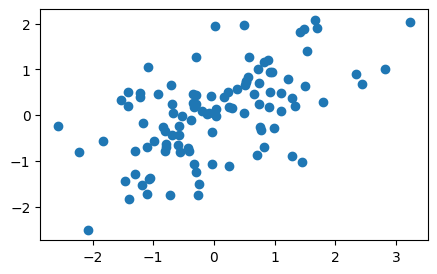

In [130]:
# Gerando as variáveis

# Definindo a matriz de covariância
n = 105
cov_value = 0.5
cov_matrix = np.full((n, n), cov_value)
np.fill_diagonal(cov_matrix, 1)

# Decomposição de Cholesky
chol_decomp = np.linalg.cholesky(cov_matrix)

# Gerando variáveis independentes
independent_vars = np.random.randn(n, n)

# Transformando as variáveis independentes para obter as variáveis correlacionadas
correlated_vars = independent_vars @ chol_decomp.T

# plotando as variáveis
plt.figure(figsize=(5, 3))
plt.scatter(correlated_vars[:, 0], correlated_vars[:, 1])
plt.show()

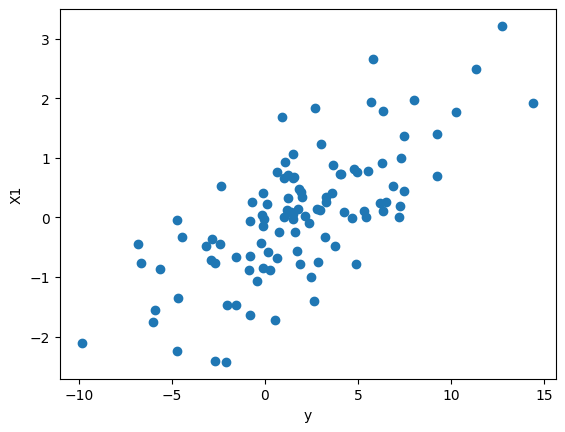

In [83]:
# Gerando a variável y usando simulação de Monte Carlo
X = correlated_vars[:, :5]

np.random.seed(0)
betas = np.random.randn(6)

num_simulations = 1000
y_outputs = np.zeros((n, num_simulations))

# Executando simulações de Monte Carlo
for i in range(num_simulations):
    error_term = np.random.randn(n)
    y_simulated = betas[0] + np.dot(X, betas[1:]) + error_term
    y_outputs[:, i] = y_simulated

# Usando a média das simulações como nossa variável y
y = np.mean(y_outputs, axis=1)

# scatter plot
plt.scatter(y, X[:, 0])
plt.xlabel('y')
plt.ylabel('X1')
plt.show()

In [84]:
# Estimando o melhor modelo linear regularizado usando validação cruzada
X = correlated_vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Regressão Ridge
ridge = RidgeCV(alphas=np.logspace(-6, 6, 50))
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

# Regressão Lasso
lasso = LassoCV(alphas=np.logspace(-6, 6, 50), max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# Regressão ElasticNet
elastic = ElasticNetCV(alphas=np.logspace(-6, 6, 50), max_iter=10000)
elastic.fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)

print(f"MSE Ridge: {mse_ridge:.4f}")
print(f"MSE Lasso: {mse_lasso:.4f}")
print(f"MSE ElasticNet: {mse_elastic:.4f}")
print(f"Alpha escolhido Ridge: {ridge.alpha_:.6f}")
print(f"Alpha escolhido Lasso: {lasso.alpha_:.6f}")
print(f"Alpha escolhido ElasticNet: {elastic.alpha_:.6f}")


MSE Ridge: 1.1781
MSE Lasso: 0.0012
MSE ElasticNet: 0.0020
Alpha escolhido Ridge: 0.000001
Alpha escolhido Lasso: 0.004715
Alpha escolhido ElasticNet: 0.002683


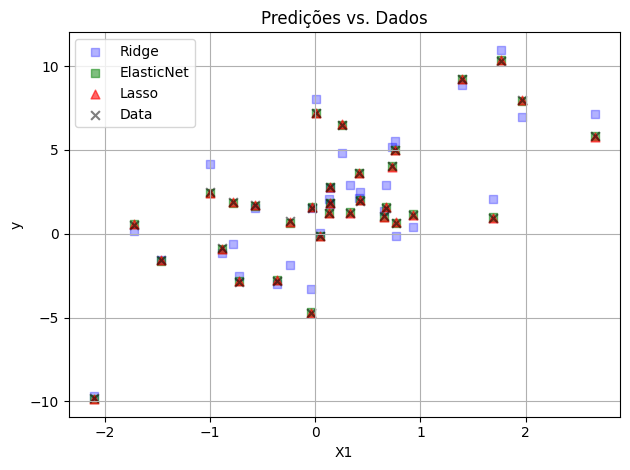

In [85]:
import matplotlib.pyplot as plt

plt.scatter(X_test[:, 0], y_pred_ridge, alpha=0.3, label='Ridge', s=40, c='blue', marker='s')  
plt.scatter(X_test[:, 0], y_pred_elastic, alpha=0.5, label='ElasticNet', s=40, c='green', marker='s') 
plt.scatter(X_test[:, 0], y_pred_lasso, alpha=0.6, label='Lasso', s=40, c='red', marker='^')   
plt.scatter(X_test[:, 0], y_test, alpha=0.5, label='Data', s=40, c='black', marker='x')

plt.title('Predições vs. Dados')
plt.xlabel('X1')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [107]:
# a) Diferença entre os modelos regularizados:

# Ridge (L2 Penalty):
# - Adiciona penalidade L2, que adiciona os valores quadrados dos coeficientes ao termo de perda.
# - Tende a encolher os coeficientes para valores próximos a zero, mas raramente exatamente zero.

# Lasso (L1 Penalty):
# - Adiciona penalidade L1, que adiciona os valores absolutos dos coeficientes ao termo de perda.
# - Pode tornar coeficientes exatamente zero, agindo como um seletor de recursos.
# - Tende a criar esparsidade (coeficientes zero). Útil quando acreditamos que muitas características são irrelevantes.
# - Pode ter múltiplas soluções se houver características altamente correlacionadas.

# ElasticNet:
# - Combina as penalidades L1 e L2.
# - Adiciona ambos os valores absolutos (L1) e quadrados (L2) dos coeficientes ao termo de perda.
# - Pode herdar os benefícios de Ridge e Lasso. Pode produzir uma solução esparsa (como Lasso) enquanto 
#   mantém as propriedades de regularização que Ridge oferece.
# - Em geral, supera o Lasso puro quando há muitas características correlacionadas.

# b) Efeito da variância e correlação na seleção de variáveis:

# Alta variância em um preditor significa que o preditor pode assumir uma ampla gama de valores, tornando-se 
# um fator dominante na predição da variável resposta, especialmente se não for adequadamente escalado.
# Se dois ou mais preditores estiverem altamente correlacionados, eles trazem informações semelhantes.
# Lasso pode descartar um (ou mais) deles e manter apenas um.

# c) Efeito do tamanho da amostra na qualidade da previsão:

# À medida que o tamanho da amostra aumenta, os modelos geralmente se beneficiam da "lei dos grandes números",
# tornando-se mais estáveis e melhores na generalização para dados não vistos.
# Com tamanhos de amostra pequenos, os modelos podem sofrer overfitting. A regularização pode ajudar 
# a mitigar esse overfitting até certo ponto.
# Um tamanho de amostra maior geralmente reduz a variância nas estimativas e previsões do modelo.


#### 2) Usando simulações Monte Carlo, gere um modelo linear com seis variáveis:
##### a) Duas variáveis que são idênticas.
##### b) Duas variáveis que possuem exatamente a mesma média, mas variâncias distintas.
##### c) Duas variáveis que são altamente correlacionadas.

#### Plote o valor dos coeficientes, estimados usando o Lasso, Ridge e Elastic-Net, associados a essas variáveis em função do fator de penalização λ e compare os resultados.

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
np.random.seed(0)

In [118]:
# Definindo parâmetros para a simulação
n_samples = 1000
n_iterations = 100

# Lista de valores lambda (ou alpha)
alphas = np.logspace(-6, 6, 100)

# Armazenando os coeficientes estimados médios para Lasso, Ridge e ElasticNet
avg_lasso_coefs = np.zeros((len(alphas), 6))
avg_ridge_coefs = np.zeros((len(alphas), 6))
avg_en_coefs = np.zeros((len(alphas), 6))

# Iniciando a simulação Monte Carlo
for iteration in range(n_iterations):

    # a) Duas variáveis idênticas
    X1 = np.random.randn(n_samples)
    X2 = X1

    # b) Duas variáveis com a mesma média, mas variâncias diferentes
    X3 = np.random.randn(n_samples)
    X4 = 2 * np.random.randn(n_samples) # escalando as variáveis para aumentar a variância

    # c) Duas variáveis altamente correlacionadas
    X5 = np.random.randn(n_samples)
    X6 = 3*X5 + 0.5*np.random.randn(n_samples)

    # Montando a matriz de design
    X = np.vstack([X1, X2, X3, X4, X5, X6]).T

    # Normalizando os dados
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Gerando a variável de resposta 'y' a partir de uma combinação linear dos recursos com algum ruído
    true_coef = [2, -1.5, 0.5, -0.5, 1.5, -1]
    y = np.dot(X, true_coef) + 0.1 * np.random.randn(n_samples)

    # Estimando coeficientes para cada valor de alpha
    for i, alpha in enumerate(alphas):
        lasso = Lasso(alpha=alpha)
        lasso.fit(X, y)
        avg_lasso_coefs[i] += lasso.coef_
        
        ridge = Ridge(alpha=alpha)
        ridge.fit(X, y)
        avg_ridge_coefs[i] += ridge.coef_
        
        en = ElasticNet(alpha=alpha)
        en.fit(X, y)
        avg_en_coefs[i] += en.coef_

# Calculando as médias dos coeficientes
avg_lasso_coefs /= n_iterations
avg_ridge_coefs /= n_iterations
avg_en_coefs /= n_iterations

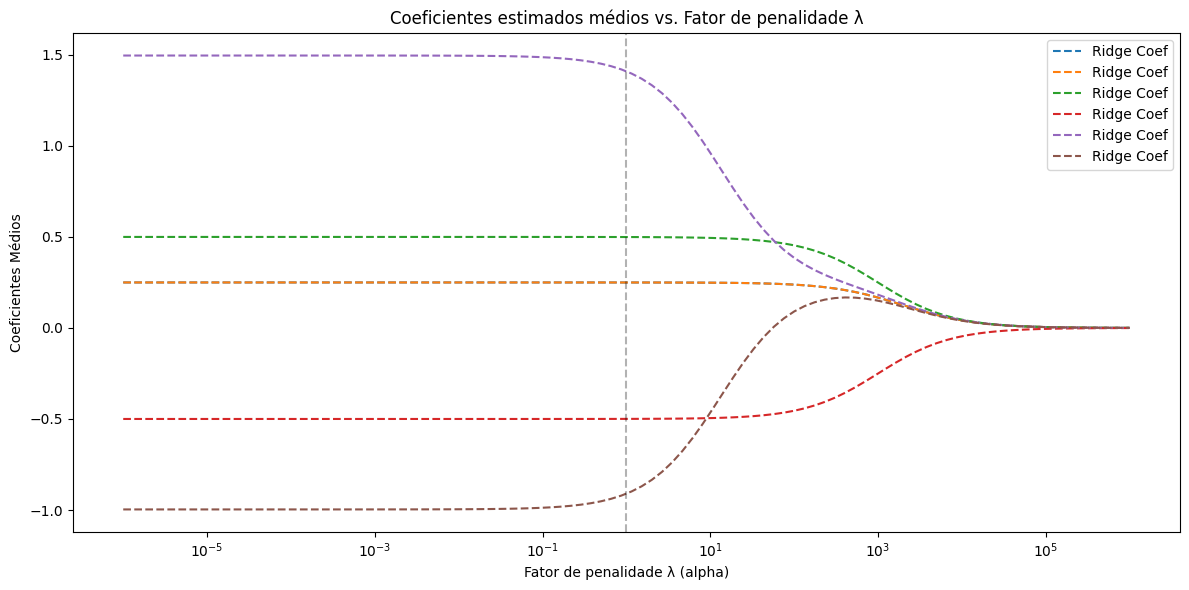

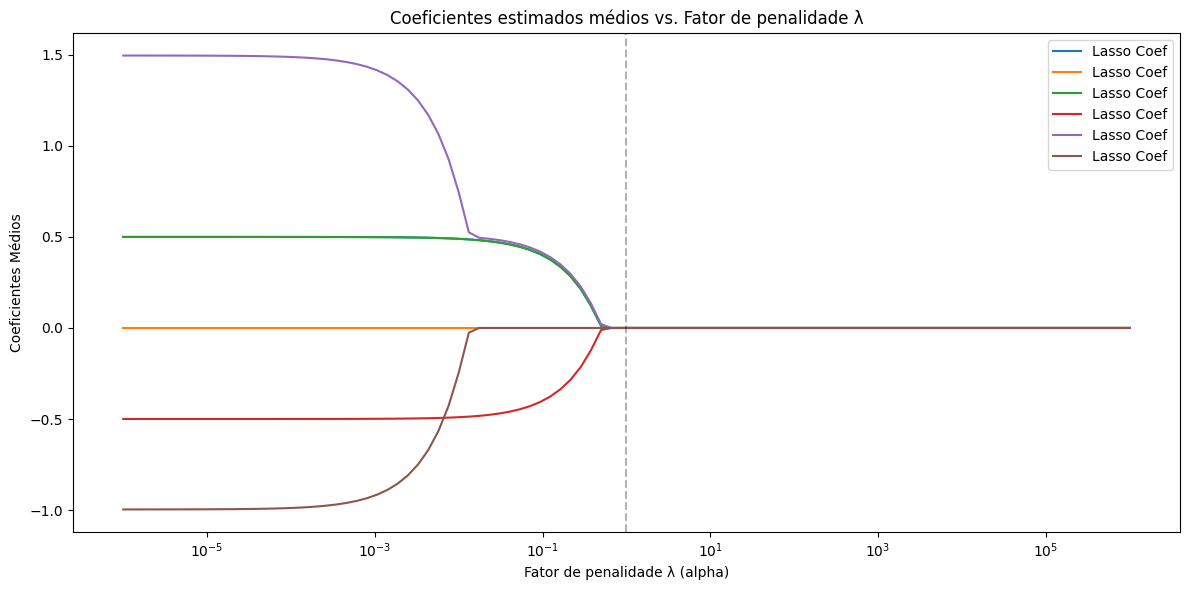

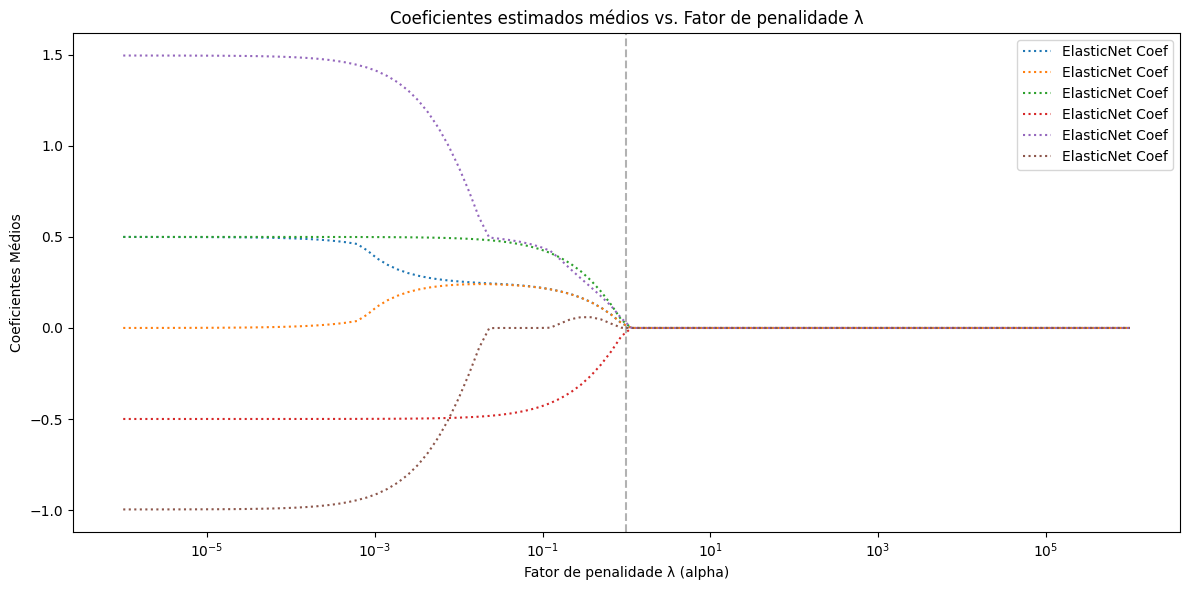

In [124]:
def plot_with_labels(alphas, coefs, label, linestyle):
    plt.figure(figsize=(12, 6))
    for i, coef in enumerate(coefs.T):  # .T para iterar pelos coeficientes
        plt.plot(alphas, coef, linestyle=linestyle, label=f'{label} Coef')
    plt.xscale('log')
    plt.xlabel('Fator de penalidade λ (alpha)')
    plt.ylabel('Coeficientes Médios')
    plt.legend()
    plt.title('Coeficientes estimados médios vs. Fator de penalidade λ')
    plt.axvline(1, linestyle='--', color='k', alpha=0.3)
    plt.tight_layout()  
    plt.show()

plot_with_labels(alphas, avg_ridge_coefs, 'Ridge', linestyle='--')
plot_with_labels(alphas, avg_lasso_coefs, 'Lasso', linestyle='-')
plot_with_labels(alphas, avg_en_coefs, 'ElasticNet', linestyle=':')

In [ ]:
# Lasso tende a fazer a seleção de variáveis, ou seja, reduzir certos coeficientes a zero mais rapidamente que os outros métodos.
# Ridge penaliza os coeficientes, mas não os reduz necessariamente a zero.
# ElasticNet combina características de Lasso e Ridge, e pode reduzir alguns coeficientes a zero enquanto penaliza outros.

#### 3) Explore os modelos discutidos nesses slides usando a base de dados de California House Prices.

In [131]:
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

class MySklearningModel:
    def __init__(self, df, independent_variable_list, dependent_variable, random_state=0):
        self.independent_variable_list = independent_variable_list
        self.dependent_variable = dependent_variable
        self.random_state = random_state
        X = df[self.independent_variable_list].values
        y = np.squeeze(df[[self.dependent_variable]].values)
        self.X_train, self.X_test, self.y_train, self.y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=self.random_state)

    def run_sklearn_regression(self, model, parameters, grid_search_cv_score, number_folds):
        scaler = StandardScaler()
        pipeline = Pipeline([('transformer', scaler), ('model', model)])
        grid_search = model_selection.GridSearchCV(pipeline,
                                                   param_grid=parameters,
                                                   scoring=grid_search_cv_score,
                                                   cv=number_folds)
        grid_search.fit(self.X_train, self.y_train)
        self.model_name = model.__class__.__name__
        print(f'\n{self.model_name}:')
        if 'model__alpha' in grid_search.best_params_:
            print(f"Melhor alpha: {grid_search.best_params_['model__alpha']}")
        print(f'{grid_search_cv_score} para os dados de teste: {grid_search.score(self.X_test, self.y_test)}')

        self.best_model = grid_search.best_estimator_  
        self.grid_search = grid_search 

    def print_coefficients(self):
        if hasattr(self.best_model.named_steps['model'], 'coef_'):
            coefficients = self.best_model.named_steps['model'].coef_
            for coef, name in zip(coefficients, self.independent_variable_list):
                print(f'{name}: {coef:.5f}')

class SklearnDatasets:
    def __init__(self, loadFunction, targetName='Target'):
        self.loadFunction = loadFunction
        self.targetName = targetName

    def dataset_to_dataframe(self):
        data = self.loadFunction()
        self.featuresNames = list(data.feature_names)
        targetData = data.target
        featuresData = data.data
        self.df = pd.DataFrame(featuresData, columns=self.featuresNames)
        self.df[self.targetName] = targetData

In [105]:
cali_data = SklearnDatasets(datasets.fetch_california_housing, 'measure')
cali_data.dataset_to_dataframe()
df = cali_data.df

In [106]:
independent_variable_list = cali_data.featuresNames
dependent_variable = 'measure'
number_folds = 5
grid_search_cv_score = 'neg_mean_squared_error'
parameters = {'model__alpha': np.logspace(-4, 2, 100)}

print("Resultados:")

# OLS
model = linear_model.LinearRegression()
model_ols = MySklearningModel(df, independent_variable_list, dependent_variable)
model_ols.run_sklearn_regression(model, {}, grid_search_cv_score, number_folds)
model_ols.print_coefficients()

# Ridge
model = linear_model.Ridge()
model_ridge = MySklearningModel(df, independent_variable_list, dependent_variable)
model_ridge.run_sklearn_regression(model, parameters, grid_search_cv_score, number_folds)
model_ridge.print_coefficients()

# Lasso
model = linear_model.Lasso()
model_lasso = MySklearningModel(df, independent_variable_list, dependent_variable)
model_lasso.run_sklearn_regression(model, parameters, grid_search_cv_score, number_folds)
model_lasso.print_coefficients()

# ElasticNet
model = linear_model.ElasticNet()
model_elasticnet = MySklearningModel(df, independent_variable_list, dependent_variable)
model_elasticnet.run_sklearn_regression(model, parameters, grid_search_cv_score, number_folds)
model_elasticnet.print_coefficients()

Resultados:

LinearRegression:
neg_mean_squared_error para os dados de teste: -0.5431489670037236
MedInc: 0.84489
HouseAge: 0.11569
AveRooms: -0.27020
AveBedrms: 0.29079
Population: -0.01077
AveOccup: -0.02806
Latitude: -0.87533
Longitude: -0.84960

Ridge:
Melhor alpha: 21.544346900318867
neg_mean_squared_error para os dados de teste: -0.5433862050175947
MedInc: 0.84423
HouseAge: 0.11761
AveRooms: -0.26708
AveBedrms: 0.28644
Population: -0.01005
AveOccup: -0.02829
Latitude: -0.85700
Longitude: -0.83112

Lasso:
Melhor alpha: 0.0021544346900318843
neg_mean_squared_error para os dados de teste: -0.5432160329236052
MedInc: 0.83461
HouseAge: 0.11776
AveRooms: -0.24480
AveBedrms: 0.26548
Population: -0.00774
AveOccup: -0.02657
Latitude: -0.85185
Longitude: -0.82496

ElasticNet:
Melhor alpha: 0.0024770763559917113
neg_mean_squared_error para os dados de teste: -0.5434025172421805
MedInc: 0.83852
HouseAge: 0.11845
AveRooms: -0.25323
AveBedrms: 0.27284
Population: -0.00844
AveOccup: -0.02739
La

# Classificadores Lineares

#### 1) Use simulações de Monte Carlo para gerar um conjunto de dados com duas variáveis independentes e linearmente separáveis. Aplique os seguintes modelos de classificação:
##### a) OLS
##### b) Discriminante Linear de Fisher
##### c) Perceptron
##### d) Logit

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [116]:
# Gerando dados sintéticos
np.random.seed(0)
n = 100  # Número de amostras por classe

# Classe 0
x0 = np.random.normal(2, 1, n)
y0 = np.random.normal(2, 1, n)

# Classe 1
x1 = np.random.normal(5, 1, n)
y1 = np.random.normal(5, 1, n)

# Combina as amostras das duas classes
X = np.vstack((np.column_stack((x0, y0)), np.column_stack((x1, y1))))
y = np.hstack((np.zeros(n), np.ones(n)))

In [117]:
# 1. OLS (Mínimos Quadrados Ordinários)
ols = LinearRegression()
ols.fit(X, y)
y_pred_ols = (ols.predict(X) > 0.5).astype(int)
print(f"Acurácia do MQO: {accuracy_score(y, y_pred_ols)}")

# 2. Discriminante Linear de Fisher
fld = LinearDiscriminantAnalysis()
fld.fit(X, y)
y_pred_fld = fld.predict(X)
print(f"Acurácia do Discriminante Linear de Fisher: {accuracy_score(y, y_pred_fld)}")

# 3. Perceptron
perceptron = Perceptron()
perceptron.fit(X, y)
y_pred_perceptron = perceptron.predict(X)
print(f"Acurácia do Perceptron: {accuracy_score(y, y_pred_perceptron)}")

# 4. Regressão Logística
logit = LogisticRegression()
logit.fit(X, y)
y_pred_logit = logit.predict(X)
print(f"Acurácia do Logit: {accuracy_score(y, y_pred_logit)}")

Acurácia do MQO: 0.98
Acurácia do Discriminante Linear de Fisher: 0.98
Acurácia do Perceptron: 0.93
Acurácia do Logit: 0.98


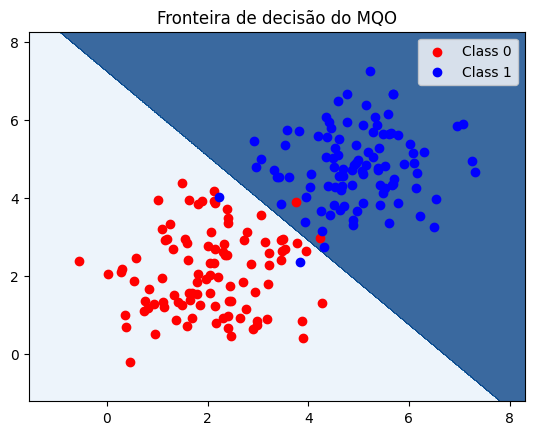

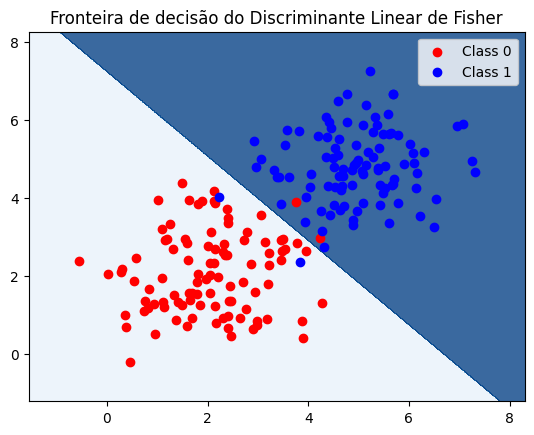

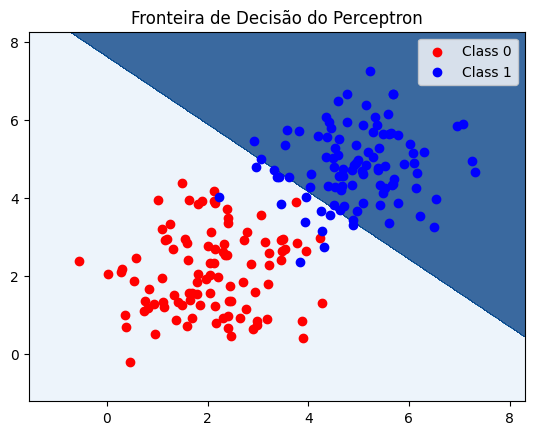

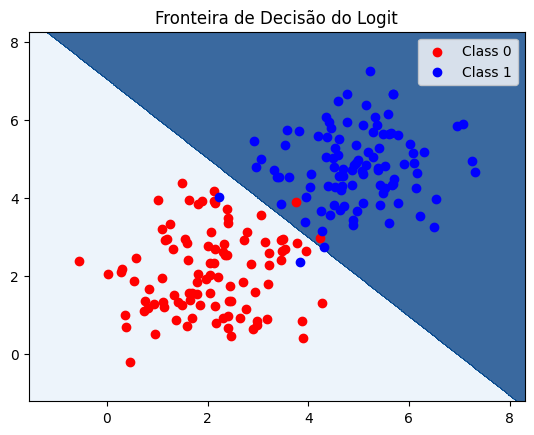

In [122]:
# Função para plotar a fronteira de decisão
def plot_decision_boundary(model, X, title):
    # Determina os limites do gráfico
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Cria uma grade de pontos para plotar a fronteira
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    if model == ols:
        Z = (model.predict(np.c_[xx.ravel(), yy.ravel()]) > 0.5).astype(int)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        
    Z = Z.reshape(xx.shape)
    
    # Plota a fronteira de decisão e os pontos originais
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Blues)
    plt.scatter(X[:n, 0], X[:n, 1], c='red', label='Class 0')
    plt.scatter(X[n:, 0], X[n:, 1], c='blue', label='Class 1')
    plt.title(title)
    plt.legend()
    plt.show()

# Plota as fronteiras de decisão para cada modelo
plot_decision_boundary(ols, X, 'Fronteira de decisão do MQO')
plot_decision_boundary(fld, X, "Fronteira de decisão do Discriminante Linear de Fisher")
plot_decision_boundary(perceptron, X, 'Fronteira de Decisão do Perceptron')
plot_decision_boundary(logit, X, 'Fronteira de Decisão do Logit')

#### 2) Compare modelos de classificação linear para classificar a existência ou não de câncer usando a base de dados "Breast Cancer Wisconsin (Diagnostic) Dataset".

In [100]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [101]:
# 1. Carregando o dataset
data = load_breast_cancer()
X = data['data']
y = data['target']

# 2. Pré-processamento (normalização)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# Regressão Logística (Logit)
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)
y_pred_logit = logit_model.predict(X_test)
acc_logit = accuracy_score(y_test, y_pred_logit)

# Fisher Linear Discriminant
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)
acc_lda = accuracy_score(y_test, y_pred_lda)

# Perceptron
perceptron_model = Perceptron()
perceptron_model.fit(X_train, y_train)
y_pred_perceptron = perceptron_model.predict(X_test)
acc_perceptron = accuracy_score(y_test, y_pred_perceptron)

# Sumarizando os resultados
print(f"Acurácia da Regressão Logística: {acc_logit}")
print(f"Acurácia do Fisher Linear Discriminant: {acc_lda}")
print(f"Acurácia do Perceptron: {acc_perceptron}")

Acurácia da Regressão Logística: 0.9736842105263158
Acurácia do Fisher Linear Discriminant: 0.956140350877193
Acurácia do Perceptron: 0.9736842105263158


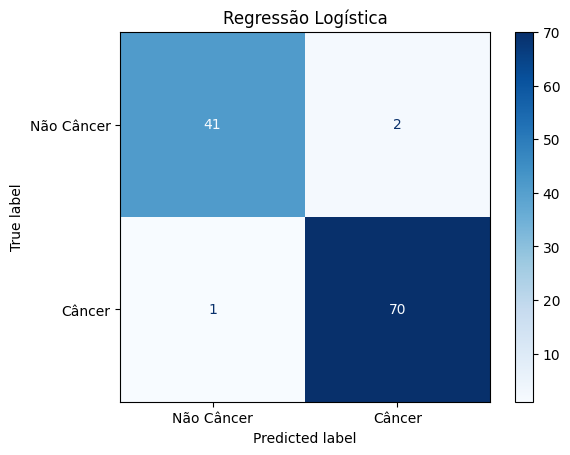

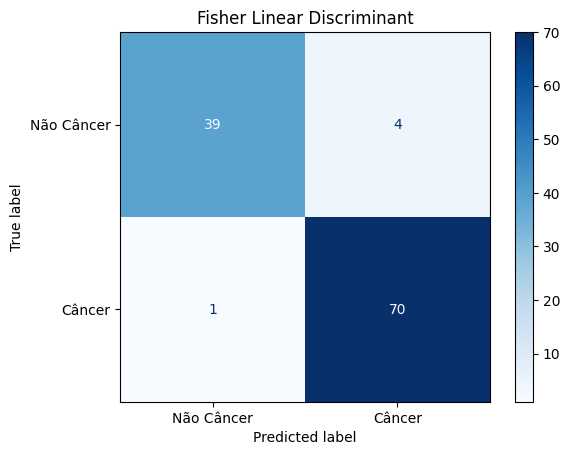

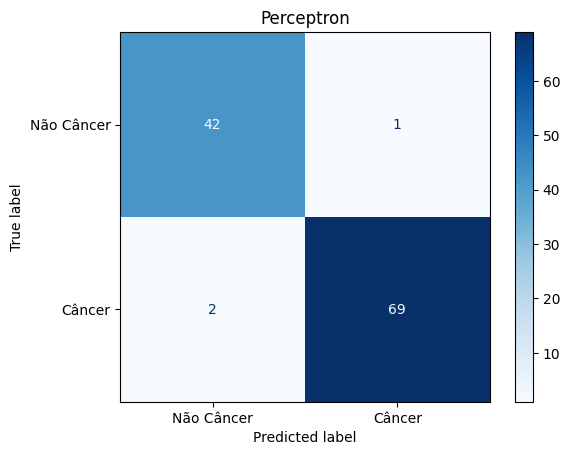

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay

# Função para plotar a matriz de confusão
def plot_conf_matrix_from_predictions(y_true, y_pred, title):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    disp.ax_.set_xticklabels(['Não Câncer', 'Câncer'])
    disp.ax_.set_yticklabels(['Não Câncer', 'Câncer'])
    plt.show()

plot_conf_matrix_from_predictions(y_test, y_pred_logit, 'Regressão Logística')
plot_conf_matrix_from_predictions(y_test, y_pred_lda, 'Fisher Linear Discriminant')
plot_conf_matrix_from_predictions(y_test, y_pred_perceptron, 'Perceptron')

In [ ]:
'''
Resumo dos Métodos para Discriminação:

1. SVM Linear (Support Vector Machine):

    - Intuição: Maximiza a margem entre diferentes classes no espaço de características.
    - Quando usar: Quando você se preocupa em maximizar a margem entre diferentes classes.
    - Prós: Robusto a outliers se você usar uma margem suave, funciona bem para dados de alta dimensão.
    - Contras: Mais computacionalmente intenso. Requer ajuste de parâmetros para margem suave.

2. OLS (Ordinary Least Squares):

    - Intuição: Minimiza a soma dos quadrados das distâncias verticais de cada ponto até uma linha.
    - Quando usar: Geralmente não é usado para discriminação, mas pode ser adaptado para isso. Mais adequado para problemas de regressão.
    - Prós: Simples, fácil de interpretar.
    - Contras: Sensível a outliers. Assume que os erros têm distribuição normal e variância constante.

3. Fisher Linear Discriminant:

    - Intuição: Projeta seus pontos de dados em uma linha de forma que a separação entre as classes projetadas seja o mais larga possível, enquanto a dispersão dentro de cada classe seja o mais estreita possível.
    - Quando usar: Quando você quer reduzir a dimensionalidade e separar classes com base em combinações lineares de características.
    - Prós: Pode ser mais estável e interpretável. Útil para redução de dimensionalidade.
    - Contras: Assume que as características para cada classe têm distribuição normal e a mesma matriz de covariância.

4. Perceptron:

    - Intuição: Ajusta uma linha que separa suas classes, escolhendo pontos que são classificados erroneamente e empurrando a linha na direção correta.
    - Quando usar: Bom para problemas simples onde uma solução rápida é necessária e os dados são linearmente separáveis.
    - Prós: Rápido, simples.
    - Contras: Só funciona para dados linearmente separáveis. Não há solução única se os dados não forem linearmente separáveis.

5. Logit (Regressão Logística):

    - Intuição: Estima a probabilidade de um evento ocorrer (como pertencer a uma classe) usando uma função logística (sigmoid).
    - Quando usar: Útil quando você quer estimar probabilidades ou quando suas classes são linearmente separáveis ou quase.
    - Prós: Fornece probabilidades, fácil de implementar e interpretar, menos sensível a outliers.
    - Contras: Pode sofrer de overfitting se houver muitas características irrelevantes. Assume que a log-odds da variável dependente é uma combinação linear das variáveis independentes.

Cada método tem suas próprias vantagens e desvantagens, e a "melhor" escolha muitas vezes depende das características específicas do seu problema.
'''

# Arvores de decisão e amigos

#### 1) Estenda a aplicação empírica da aula para considerar o modelo linear e o conjunto de modelos regularizados (não se esqueça de normalizar os dados).

In [104]:
from sklearn import datasets, model_selection
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
np.random.seed(0)

In [105]:
class MySklearningModel:
    def __init__(self, df, independent_variable_list, dependent_variable, random_state=0):
        self.independent_variable_list = independent_variable_list
        self.dependent_variable = dependent_variable
        self.random_state = random_state
        X = df[self.independent_variable_list].values
        y = np.squeeze(df[[self.dependent_variable]].values)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=self.random_state)

    def run_sklearn(self, model, parameters, grid_search_cv_score, number_folds):
        # Se o modelo é do tipo que requer escalonamento, então escalona
        if isinstance(model, (LinearRegression, Ridge, Lasso, ElasticNet)):
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            
            # Prefixa os hiperparâmetros com 'model__'
            parameters = {'model__' + key: value for key, value in parameters.items()}
        
        # Configura e executa a busca em grade
        grid_search = GridSearchCV(model, param_grid=parameters, scoring=grid_search_cv_score, cv=number_folds)
        grid_search.fit(self.X_train, self.y_train)
        print(grid_search.best_params_)
        print(f"{grid_search_cv_score} para dados de teste: {grid_search.score(self.X_test, self.y_test):.6f}")
        
        # Atribui o melhor modelo encontrado
        self.model = model
        self.model.set_params(**grid_search.best_params_)  # Define os melhores parâmetros
        self.model.fit(self.X_test, self.y_test)


class SklearnDatasets:
    def __init__(self, loadFunction, targetName='Target'):
        self.loadFunction = loadFunction
        self.targetName = targetName
        
    def dataset_to_dataframe(self):
        data = self.loadFunction()
        self.featuresNames = list(data.feature_names)
        targetData = data.target
        featuresData = data.data
        self.df = pd.DataFrame(featuresData, columns=self.featuresNames)
        self.df[self.targetName] = targetData

In [106]:
breast = SklearnDatasets(datasets.load_breast_cancer, 'kind')
breast.dataset_to_dataframe()
df = breast.df
independent_variable_list = breast.featuresNames
number_folds = 5
dependent_variable = 'kind'
my_model = MySklearningModel(df, independent_variable_list, dependent_variable)
grid_search_cv_score = 'accuracy'  # Métrica de classificação

In [107]:
# Decision Tree
print('Decision Tree: ')
parameters = {'max_depth': [2, 4, 6, 8, 10]}
model = DecisionTreeClassifier(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Random Forest
print('\nRandom Forest: ')
parameters = {'max_depth': [2, 4, 6, 8, 10]}
model = RandomForestClassifier(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Gradient Boosting
print('\nGradient Boosting: ')
parameters = {'max_depth': [2, 4, 6, 8, 10]}
model = GradientBoostingClassifier(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Logistic Regression (which is the classifier analog of Linear Regression)
print('\nLogistic Regression: ')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
model = LogisticRegression(random_state=0, max_iter=10000)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Lasso Classifier (analogous to Lasso regression but for classification)
print('\nLasso Classifier: ')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
model = LogisticRegression(penalty='l1', solver='saga', random_state=0, max_iter=10000)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Ridge Classifier (analogous to Ridge regression but for classification)
print('\nRidge Classifier: ')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
model = LogisticRegression(penalty='l2', solver='saga', random_state=0, max_iter=10000)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# ElasticNet Classifier (analogous to ElasticNet regression but for classification)
print('\nElasticNet Classifier: ')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.2, 0.5, 0.8]}
model = LogisticRegression(penalty='elasticnet', solver='saga', random_state=0, max_iter=10000)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

Decision Tree: 
{'max_depth': 4}
accuracy para dados de teste: 0.947368

Random Forest: 
{'max_depth': 8}
accuracy para dados de teste: 0.959064

Gradient Boosting: 
{'max_depth': 2}
accuracy para dados de teste: 0.964912

Logistic Regression: 
{'C': 100}
accuracy para dados de teste: 0.970760

Lasso Classifier: 
{'C': 0.01}
accuracy para dados de teste: 0.953216

Ridge Classifier: 
{'C': 0.01}
accuracy para dados de teste: 0.953216

ElasticNet Classifier: 
{'C': 0.01, 'l1_ratio': 0.8}
accuracy para dados de teste: 0.953216


#### 2) Compare os modelos discutidos nesses slides com os modelos usados nas aulas anteriores (Linear, Lasso, Ridge, Elastic Net), usando a base de dados de preços de casas na Califórnia.

In [ ]:
california = SklearnDatasets(datasets.fetch_california_housing, 'Price')
california.dataset_to_dataframe()
df = california.df
independent_variable_list = california.featuresNames
dependent_variable = 'Price'
my_model = MySklearningModel(df, independent_variable_list, dependent_variable)
grid_search_cv_score = 'neg_mean_squared_error' # Métrica de regressão

In [95]:
# Decision Tree Regressor
print('Decision Tree: ')
parameters = {'max_depth': [2,4,6,8,10]}
model = DecisionTreeRegressor(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Random Forest Regressor
print('\nRandom Forest: ')
parameters = {'max_depth': [2,4,6,8,10]}
model = RandomForestRegressor(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Gradient Boosting Regressor
print('\nGradient Boosting: ')
parameters = {'max_depth': [2,4,6,8,10]}
model = GradientBoostingRegressor(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Linear Regression
print('\nLinear Regression: ')
parameters = {}
model = LinearRegression()
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Lasso Regression
print('\nLasso: ')
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
model = Lasso(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# Ridge Regression
print('\nRidge: ')
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
model = Ridge(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

# ElasticNet
print('\nElasticNet: ')
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
model = ElasticNet(random_state=0)
my_model.run_sklearn(model, parameters, grid_search_cv_score, number_folds)

Decision Tree: 
{'max_depth': 8}
neg_mean_squared_error para dados de teste: -0.443317

Random Forest: 
{'max_depth': 10}
neg_mean_squared_error para dados de teste: -0.313221

Gradient Boosting: 
{'max_depth': 8}
neg_mean_squared_error para dados de teste: -0.221619

Linear Regression: 
{}
neg_mean_squared_error para dados de teste: -0.543149

Lasso: 
{'model__alpha': 0.001}
neg_mean_squared_error para dados de teste: -0.543123

Ridge: 
{'model__alpha': 10}
neg_mean_squared_error para dados de teste: -0.543249

ElasticNet: 
{'model__alpha': 0.001, 'model__l1_ratio': 0.8}
neg_mean_squared_error para dados de teste: -0.543156


# Modelos não-supervisionados

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

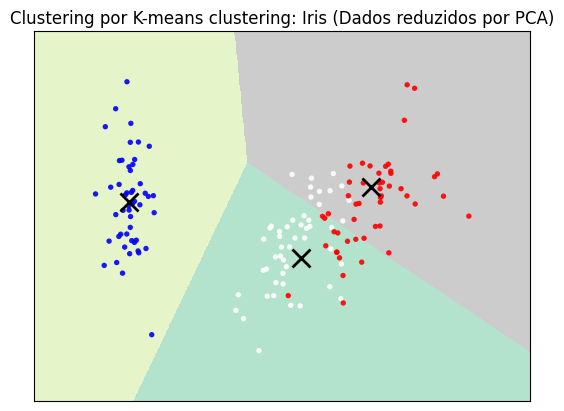

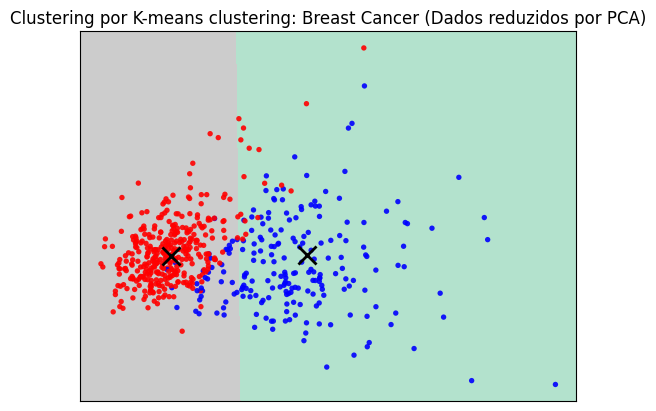

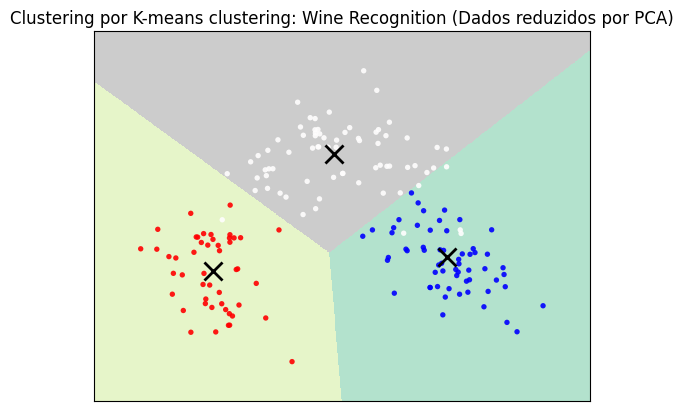

In [108]:
def perform_kmeans_clustering(dataset, dataset_name):
    np.random.seed(42)
    
    # Extraindo os dados e os rótulos do conjunto de dados
    X, y = dataset.data, dataset.target
    
    # Normalizando os dados
    data = scale(X)
    
    # Obtém o número de rótulos únicos (clusters)
    n_digits = len(np.unique(y))

    # Análise de Componentes Principais (PCA) para reduzir a dimensionalidade
    reduced_data = PCA(n_components=2).fit_transform(data)
    
    # Inicializando e ajustando o modelo K-means nos dados reduzidos
    kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data)

    # Obtendo os limites dos eixos x e y para a plotagem
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    
    # Tamanho do espaço do grid de pontos (aumentar para melhorar a qualidade)
    h = .01
    # Gerando um grid de pontos para plotar a região de cada cluster
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Realizando a previsão para cada ponto no grid
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Configurando a plotagem
    plt.figure()
    plt.clf()
    plt.title(f'Clustering por K-means clustering: {dataset_name} (Dados reduzidos por PCA)')
    
    # Regiões dos clusters
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Pastel2,
               aspect='auto', origin='lower')

    # Pontos de dados reais
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y, edgecolor='none', alpha=0.9,
                cmap=plt.cm.bwr,
                s=15)

    # Centróides dos clusters
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=2,
                color='k', zorder=10)

    # Configurando os limites dos eixos
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Removendo as marcações dos eixos
    plt.xticks(())
    plt.yticks(())

# Lista de conjuntos de dados para processar
datasets_list = [
    (datasets.load_iris(), 'Iris'),
    (datasets.load_breast_cancer(), 'Breast Cancer'),
    (datasets.load_wine(), 'Wine Recognition')
]

# Loop para aplicar a função de clustering em cada conjunto de dados
for dataset, dataset_name in datasets_list:
    perform_kmeans_clustering(dataset, dataset_name)

# Mostra o gráfico
plt.show()


Dataset: Iris
Calculando projeção de PCA


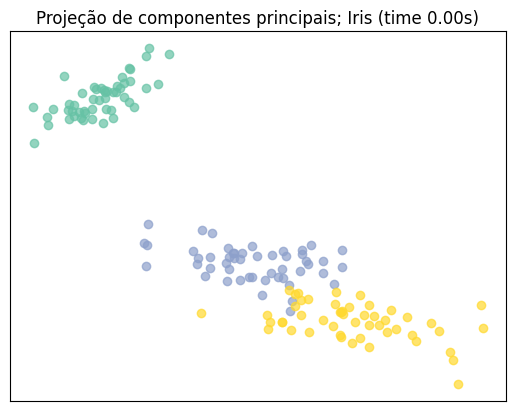

Calculando t-SNE


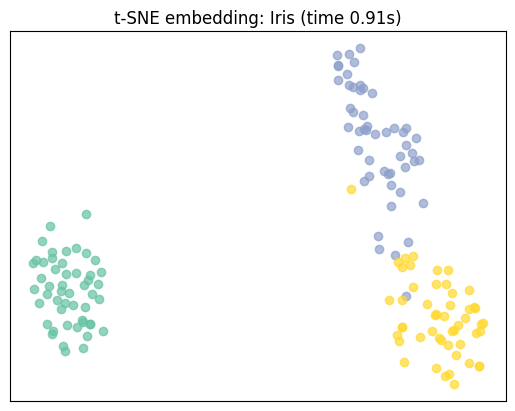

Dataset: Breast Cancer
Calculando projeção de PCA


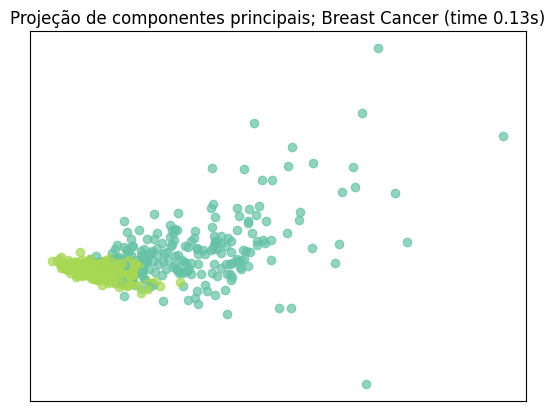

Calculando t-SNE


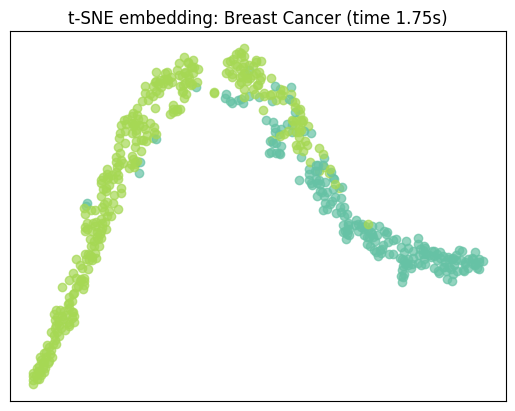

Dataset: Wine Recognition
Calculando projeção de PCA


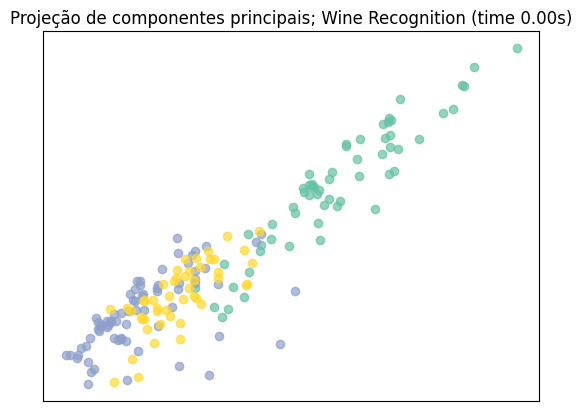

Calculando t-SNE


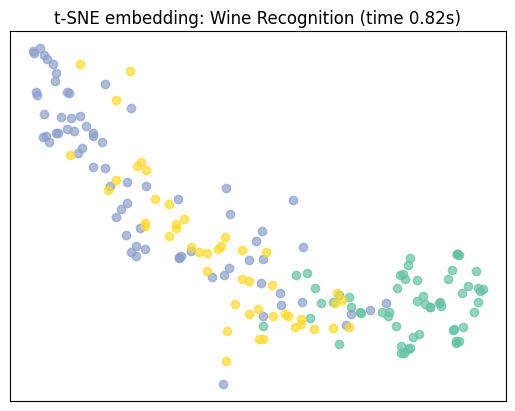

In [68]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (manifold, datasets, decomposition)

# Função para plotar os dados em um espaço de dimensão reduzida
def plot_embedding(X, y, title=None):
    # Normaliza os dados de entrada
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    unique_labels = np.unique(y)
    
    # Plota cada ponto de dado
    for i in range(X.shape[0]):
        label = y[i]
        plt.scatter(X[i, 0], X[i, 1], 
                    color=plt.cm.Set2(unique_labels.tolist().index(label) / float(len(unique_labels))), 
                    alpha=0.7)
    plt.xticks([]), plt.yticks([])
    
    # Adiciona título se fornecido
    if title is not None:
        plt.title(title)
    
    # Mostra o gráfico
    plt.show()
    

# Função para processar e visualizar um conjunto de dados
def process_dataset(dataset, dataset_name):
    print(f"Dataset: {dataset_name}")
    X = dataset.data
    y = dataset.target

    # Projeção nas duas primeiras componentes principais usando PCA
    print("Calculando projeção de PCA")
    t0 = time()
    X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
    plot_embedding(X_pca, y, f"Projeção de componentes principais; {dataset_name} (time %.2fs)" % (time() - t0))

    # Redução de dimensionalidade usando t-SNE
    print("Calculando t-SNE")
    t0 = time()
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X)
    plot_embedding(X_tsne, y, f"t-SNE embedding: {dataset_name} (time %.2fs)" % (time() - t0))

# Carrega os conjuntos de dados e aplica redução de dimensionalidade
datasets_list = [
    (datasets.load_iris(), 'Iris'),
    (datasets.load_breast_cancer(), 'Breast Cancer'),
    (datasets.load_wine(), 'Wine Recognition')
]

# Processa cada conjunto de dados na lista
for dataset, dataset_name in datasets_list:
    process_dataset(dataset, dataset_name)


# Knn e Dados Faltantes

#### Explore a base de dados "COVID-19 Open Research Dataset Challenge (CORD-19)" (https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/139347):
##### a) Inclua no grupo de modelos já estudados nessa base o KNN.
##### b) Explore as técnicas para lidar com dados faltantes.

In [110]:
# Comentário:
# Tive problemas com o download dessa base para esse exercício, mas recomendo que revisem os códigos da aula para essa parte.
# O mais importante são as técnicas de imputação de dados faltantes, que são muito úteis para o dia a dia.
# A implementação de imputação de dados faltantes é bastante direta, com os métodos mostrados no código dos slides.